In [54]:
# IND ENG 162: Homework 7
# Christian Granados

import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cvxpy as cp
import warnings

np.set_printoptions(threshold = sys.maxsize)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

warnings.filterwarnings("ignore")

In [3]:
# 1) Optimal resource allocation as LP
# Demand in California for 4/10/2023 at 8pm: 19,667 mW (Normalized: 1.996)

In [4]:
Laplacian = np.genfromtxt("L.csv", delimiter = ",")

line_cap = np.full((57, 57), np.pi / 10)
line_cap[3][5] = 0
line_cap[7][8] = 0

In [16]:
gen_bus = cp.Variable(7)
phases = cp.Variable(57)
load_bus = (np.random.dirichlet(np.ones(50), size = 1) * 1.996)[0]

p_gen_bus = np.zeros(57, dtype = object)
for i, j in zip([0, 1, 2, 5, 7, 8, 11], np.arange(7)):
    p_gen_bus[i] = gen_bus[j]

p_load_bus = np.zeros(57)
for i, j in zip([3, 4, 6, 9, 10] + list(np.arange(12, 57)), np.arange(50)):
    p_load_bus[i] = load_bus[j]

obj_weights = np.array([1, 2, 3, 4, 5, 6, 7])
obj = cp.Minimize(obj_weights @ gen_bus)
constraints = [x == y for x, y in zip(p_gen_bus - p_load_bus, Laplacian @ phases)]
constraints += [(phases[i] - phases[j]) <= line_cap[i][j] for i in np.arange(57) for j in np.arange(57)]
constraints += [x >= 0 for x in gen_bus]

prob = cp.Problem(obj, constraints)
result = prob.solve(solver = "SCIPY", verbose = True)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Apr 23 09:13:40 PM: Your problem has 64 variables, 3313 constraints, and 0 parameters.
(CVXPY) Apr 23 09:13:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 23 09:13:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 23 09:13:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 23 09:13:40 PM: Compiling problem (target solver=SCIPY).
(CVXPY) Apr 23 09:13:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

In [6]:
print("Optimal cost of", result)
for x, n in zip((gen_bus.value * 10000), [1, 2, 3, 6, 8, 9, 12]):
    print("Generator", n, "Optimal mW Production:", np.round(x, 2))

Optimal cost of 4.242518320810946
Generator 1 Optimal mW Production: 14033.25
Generator 2 Optimal mW Production: -0.0
Generator 3 Optimal mW Production: 96.55
Generator 6 Optimal mW Production: 3439.44
Generator 8 Optimal mW Production: -0.0
Generator 9 Optimal mW Production: 2390.75
Generator 12 Optimal mW Production: -0.0


In [ ]:
# 2) Pricing and Duality
# Power demand overtime for California on 4/10/2023 (From hour 0, 12am to hour 23, 11pm)
# 20477, 19854, 18902, 18973, 19687, 21188, 22541, 22070, 20816, 19115, 17753, 17151, 17166, 17604, 18392, 19667, 21663, 23959, 26034, 26869, 26126, 24958, 23422 
# Due to the random nature of the load_bus vector, some problems can be infeasible; after running this section many times, I found a random division that allows all
# problems to be feasible. I saved this and am using this for the problem. The code that gets a randomized load_bus is commented out, but can be uncommented and works
# with the code; many iteration just won't be feasible when you select load_bus randomly.

gens_ot = pd.DataFrame(columns = ["Load_" + str(x) for x in [3, 4, 6, 9, 10] + list(np.arange(12, 57))])

pre_load_ran = np.ndarray.flatten(np.genfromtxt("PLR.csv", delimiter = ","))
pre_load_ran = pre_load_ran[~np.isnan(pre_load_ran)]
#pre_load_ran = np.random.dirichlet(np.ones(50), size = 1)

for pwr in [2.0477, 1.9854, 1.8902, 1.8973, 1.9687, 2.1188, 2.2541, 2.2070, 2.0816, 1.9115, 1.7753, 1.7151, 1.7166, 1.7604, 1.8392, 1.9667, 2.1663, 2.3959, 2.6034, 2.6869, 2.6126, 2.4958, 2.3422]:
    gen_bus_qp = cp.Variable(7)
    phases_qp = cp.Variable(57)
    load_bus_qp = (pre_load_ran * pwr)

    obj_qp = cp.Minimize((obj_weights @ gen_bus_qp) + 0.3 * cp.quad_form(gen_bus_qp, np.diag(np.ones(7))))

    p_gen_bus_qp = np.zeros(57, dtype = object)
    for i, j in zip([0, 1, 2, 5, 7, 8, 11], np.arange(7)):
        p_gen_bus_qp[i] = gen_bus_qp[j]

    p_load_bus_qp = np.zeros(57)
    for i, j in zip([3, 4, 6, 9, 10] + list(np.arange(12, 57)), np.arange(50)):
        p_load_bus_qp[i] = load_bus_qp[j]

    constraints_qp = [x == y for x, y in zip(p_gen_bus_qp - p_load_bus_qp, Laplacian @ phases_qp)]
    constraints_qp += [(phases_qp[i] - phases_qp[j]) <= line_cap[i][j] for i in np.arange(57) for j in np.arange(57)]
    constraints_qp += [x >= 0 for x in gen_bus_qp]

    prob_qp = cp.Problem(obj_qp, constraints_qp)
    result_qp = prob_qp.solve(solver = "OSQP", eps_abs = 1e-24)
    gens_ot.loc[len(gens_ot)] = [constraints_qp[i].dual_value for i in [3, 4, 6, 9, 10] + list(np.arange(12, 57))]


In [50]:
gens_ot

,Load_3,Load_4,Load_6,Load_9,Load_10,Load_12,Load_13,Load_14,Load_15,Load_16,Load_17,Load_18,Load_19,Load_20,Load_21,Load_22,Load_23,Load_24,Load_25,Load_26,Load_27,Load_28,Load_29,Load_30,Load_31,Load_32,Load_33,Load_34,Load_35,Load_36,Load_37,Load_38,Load_39,Load_40,Load_41,Load_42,Load_43,Load_44,Load_45,Load_46,Load_47,Load_48,Load_49,Load_50,Load_51,Load_52,Load_53,Load_54,Load_55,Load_56
0,-1.6727292698151814,2.4143298969304983,2.0162084493471717,4.475261635517152,4.60389351542591,3.4634783999936154,2.800407507100719,1.9400675460725787,3.101202652740378,2.4860585300448386,-1.3092433360487359,0.2229599798665983,1.1752077419238676,2.4223671995519975,2.673768415161712,2.665692309423728,2.5300309749774783,2.5925658105202274,2.5065080001795295,2.3342907909480934,2.2697143094388665,2.2275328927910842,2.62288312886654,2.6966303290719393,2.810281560155023,2.8102815601550235,2.9066809408565493,2.9183698012890527,2.927513259832646,2.8957134809002625,2.754089680440034,2.9199376548454357,2.969532752250768,4.260512112494256,3.9822283090708632,4.513787664180946,2.573384522802067,2.187152857523569,2.8231365478042423,2.849174239935593,2.862064787397415,3.213686036489414,3.621035903550771,4.323833891140773,3.091006833054786,3.546808381585974,4.658802098041037,5.6981775890583,3.6993449702663566,3.5271939752893986
1,-1.7168058757520155,2.391836826001392,1.9909013086383167,4.465714837880599,4.595071580495429,3.4482279925502604,2.7814165057573463,1.916251048337064,3.083925649180826,2.4653232149768387,-1.3512968842397455,0.18943423288737302,1.1469819310137273,2.401082718048716,2.6538831602289847,2.645730996982551,2.5087920587720967,2.571771212962895,2.4850593898397935,2.3113069607256316,2.2461548160825533,2.2035973757504475,2.6023039400455255,2.6765751242993083,2.7910338630843907,2.791033863084391,2.8881181747069613,2.8998900861080887,2.9090985101881435,2.877125218462824,2.7347118191607125,2.9014878120965077,2.9513585529043733,4.249725934208326,3.969850264984582,4.504450297086452,2.5530213265218276,2.164683647318568,2.8042429711805124,2.8303922700835322,2.843338070997926,3.1969701538859203,3.6066348452118597,4.313426583546178,3.0723311564201414,3.5309092142242617,4.64967662610693,5.695383459565146,3.685348749674678,3.512214064308303
2,-1.7841588915656006,2.3574653917726454,1.9522297228360221,4.451126472952834,4.581590870938739,3.424923999153674,2.752396548648373,1.8798572989884133,3.0575248347527464,2.4336377897043917,-1.4155584859698245,0.13820387795282887,1.103850354791492,2.3685581170998815,2.623496703253132,2.6152283172971567,2.4763370856942073,2.5399951987179783,2.4522839852757,2.2761856021834435,2.2101537925268393,2.1670217542052055,2.5708570897122853,2.6459289686916856,2.76162165183038,2.7616216518303807,2.859752599467148,2.871651420213591,2.880959117472957,2.8487206826033757,2.7051007052956835,2.8732947939633227,2.9235867426671955,4.233243684243309,3.950935500987569,4.490181960852169,2.5219045322059586,2.130348674421042,2.775371887800432,2.801691731882631,2.814721965039157,3.1714267827165386,3.5846287335928517,4.297523282053315,3.043793043809897,3.5066138573569265,4.63573208472447,5.691113778541897,3.6639612665233523,3.4893234138203386
3,-1.7791357149660574,2.3600288075607145,1.9551138432057324,4.45221447075732,4.582596259991812,3.4266620070645537,2.754560852172256,1.8825715386982393,3.0594938030556804,2.436000883395929,-1.4107658665130631,0.14202462921370443,1.1070671004971426,2.3709837963723266,2.625762920107424,2.6175032020215934,2.478757572131739,2.5423650485198594,2.4547283694396196,2.278804947200772,2.2128387428130343,2.169749557912888,2.5732023905249557,2.64821455382629,2.763815209602478,2.763815209602479,2.8618680993012124,2.873757455170011,2.883057748652348,2.8508390881139043,2.7073090971910805,2.875397424517375,2.9256579596071552,4.234472927675576,3.952346160907516,4.491246090970483,2.524225217496323,2.132909370929156,2.7775250883466356,2.803832213198035,2.816856149412133,3.1733318030453477,3.5862699456988905,4.2987093476058

In [52]:
gens_ot_df = pd.DataFrame()
gens_ot_df["Load Bus"]  = np.mean(gens_ot).index
gens_ot_df["LMP"] = np.mean(gens_ot).to_list()
gens_ot_df["STD"] = np.std(gens_ot).to_list()
gens_ot_df.sort_values(by = ["LMP"], ascending = True)

,Load Bus,LMP,STD
0,Load_3,-1.457302,0.923609
10,Load_17,-1.090557,0.941688
11,Load_18,0.455385,1.019546
12,Load_19,1.416171,1.069094
7,Load_14,2.041162,0.428989
2,Load_6,2.127268,0.472438
37,Load_44,2.331098,0.628420
21,Load_28,2.356454,0.556495
20,Load_27,2.432399,0.713458
1,Load_4,2.492285,0.325850


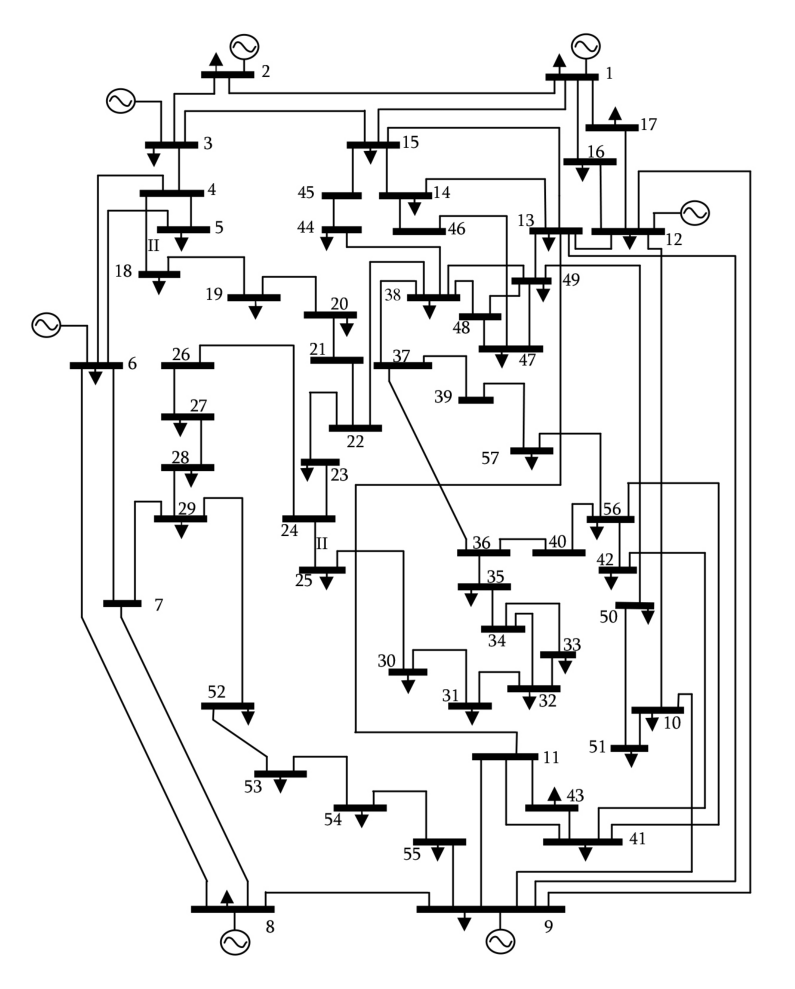

In [68]:
img = mpimg.imread("IEEE57.jpg")
plt.figure(figsize = (10, 10))
imgplot = plt.imshow(img)

plt.axis('off')
plt.tight_layout()
plt.show()

Almost all load buses fluctuate in LMP up and down with the increasing and decreasing trend of the daily demand. We see the highest LMP values
for near-maximal daily demand values (18-21). Load buses with a higher average LMP value tended to fluctuate more than their lower average
LMP counterparts. Higher average LMP load buses also tended to either be (1) far away from any generator bus or (2) connected to generators
with a lot of other connected load buses. 

In addition, the farther a load bus is from the generator buses, the more volatile its pricing is. This could be because power needs to travel 
through many other buses, and from far away sources; this adds more constraints and limitations to power delivery. For example, load buses 32, and 33 have
the highest LMP STD and the near-highest average LMP out of all of the load buses. These two load buses (using the IEEE Diagram)
are no less than 8 connections away from any generator bus. Conversely, the lowest average LMP and LMP STD tend to be for load buses that are very 
close to generator buses. (Near direct connections) Buses 4, and 18 even have negative values associated with them. This could be due to their
close proximity to generator buses, but said buses not producing much of any power in an optimal solution. Increasing the amount of power required
by these negative LMP load buses could force non-producing generator buses to produce and lower the production of other buses. Because the objective
is quadratic, this could lead to a lower overall objective value. (i.e. 0^2 + 5^2 > 3^2 + 2^2; dividing the power produces lower squared values)

In [124]:
# 3) Cyberattack Detection as LP

injections = [x if (type(x) == int) else np.round(x.value, 3) for x in p_gen_bus] - p_load_bus_qp
line_flows = [[phases.value[i] - phases.value[j] for j in np.arange(57)] for i in np.arange(57)]

injections_measured = injections.copy()
line_flows_measured = line_flows.copy()

n = 3
for ind in np.random.randint(0, 56, n):
    print(ind)
    injections_measured[ind] += 250

e_i = cp.Variable(57)
e_ij = cp.Variable((57, 57))
phases_3 = cp.Variable(57)

obj_3 = cp.Minimize(cp.norm(e_i, 1) + cp.norm(e_ij, 1))
const_3 = [(x + z) == y for x, y, z in zip(injections_measured, Laplacian @ phases_3, e_i)]
const_3 += [line_flows_measured[i][j] + e_ij[i][j] == (phases_3[i] - phases_3[j]) * (-1 * Laplacian[i][j]) if i != j else True for i in np.arange(56) for j in np.arange(56)]
const_3 = list(filter(lambda a: a != True, const_3))

prob_3 = cp.Problem(obj_3, const_3)
result_3 = prob_3.solve(verbose = True)

8
24
37
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Apr 24 04:02:16 PM: Your problem has 3363 variables, 3137 constraints, and 0 parameters.
(CVXPY) Apr 24 04:02:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 24 04:02:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 24 04:02:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 24 04:02:17 PM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 24 04:02:17 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatr

In [125]:
print(result_3)
print(e_i.value)

756.6873887648128
[-1.31493158e+00 -7.87868085e-03 -8.73357079e-03 -7.72993490e-03
 -8.10430132e-03 -1.11245620e-02 -1.07145256e-02 -2.25259654e-02
 -2.48635056e+02 -6.04430143e-02 -5.62753347e-02 -4.76185933e-02
 -5.05139251e-02 -2.64401484e-02 -3.33765578e-02 -8.29903434e-02
 -1.87937589e-02 -7.04531213e-03 -8.09891787e-03 -8.95288876e-03
 -1.37980255e-02 -2.60470793e-02 -1.45502548e-02 -5.69279393e-03
 -2.50001244e+02 -7.04210444e-03 -5.84894697e-03 -6.18166404e-03
 -7.83395010e-03 -2.10924692e-02 -5.20890504e-03 -3.43887624e-03
 -2.13396810e-03 -6.30221068e-03 -7.74966796e-03 -1.09299461e-02
 -2.10881860e-02 -2.48650785e+02 -1.31924647e-02 -8.27844336e-03
 -1.68090645e-02 -1.18389253e-02 -2.36369146e-02 -4.42520325e-02
 -3.31754831e-02 -1.93263048e-02 -1.86680190e-02 -3.63376310e-02
 -3.51466319e-02 -2.60446731e-02 -2.84253840e-02 -9.17132592e-03
 -1.09947166e-02 -1.61856997e-02 -3.49537782e-02 -1.13529850e-02
 -1.16935949e-02]


For z = 1, 2, 3 the Lassso LP correctly finds the buses undergoing an injection cyberattack. What I did notice was that the more injection attacks existed (i.e. going from 1 to 3), the lagrer the attack needed to be in order for the LP to recognize it. For example, +150 worked for z = 1, but not z = 3; a higher number, such as +250 was needed for z = 3 to be correctly recognized. Besides that I got the weight of each edge (the X_ij) from the weighted lapplacian, and minimized the L1 norm of the injections and line flows using the norm features of CVXPY. Something I was suprised at was how different the phases were from our optimal ones in part 1 (even after using the same load_bus configuration). Most phase entries were similar or within a magnitude of the optimal phases in Part 1, but a select few differed substantially. Larger differences occured with larger values of z and injection attack strength.

Note: The difference between phases for Part 1 and Part 3 can be viewed by comparing the difference of the "phases.value" and "phases_3.value" arrays